# About This Demo

The GPU transcoding and filter module demo shows:
1. Common video/image filters in BMF accelerated by GPU
2. How to write GPU modules in BMF

The demo builds a transcoding pipeline which fully runs on GPU:

decode->scale->flip->rotate->crop->blur->encode




# Get Started

## 1. Environment Setup
*   install the BMF
*   make sure the GPU environment is ready

### 1-1 pip install BMF packages

To install a GPU supported version of BMF:

In [ ]:
!pip uninstall BabitMF-GPU
!pip3 install -i https://test.pypi.org/simple/ BabitMF-GPU

In [ ]:
%env LIBRARY_PATH=$LIBRARY_PATH:/usr/local/lib/python3.10/dist-packages/bmf/lib

env: LIBRARY_PATH=$LIBRARY_PATH:/usr/local/lib/python3.10/dist-packages/bmf/lib


### 1-2 verify the FFmpeg libraries is installed and version is correct

Part of feature in BMF framework utilizes the FFmpeg demuxer/muxer/codec and filter as the built-in modules for video processing. **If the capability of ffmpeg is needed,it's neccessary for users to install supported FFmpeg libraries before using BMF.**

**Optional step**

Install ffmpeg and related libraries. For this demo, we don't have to do this step, because ffmpeg libraries are already installed in the Google Colab environment.

In [ ]:
!sudo apt install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


List the ffmpeg libraries. It is expected that the related libraries such libavcodec, libavformat are installed. The output should be showned as below:
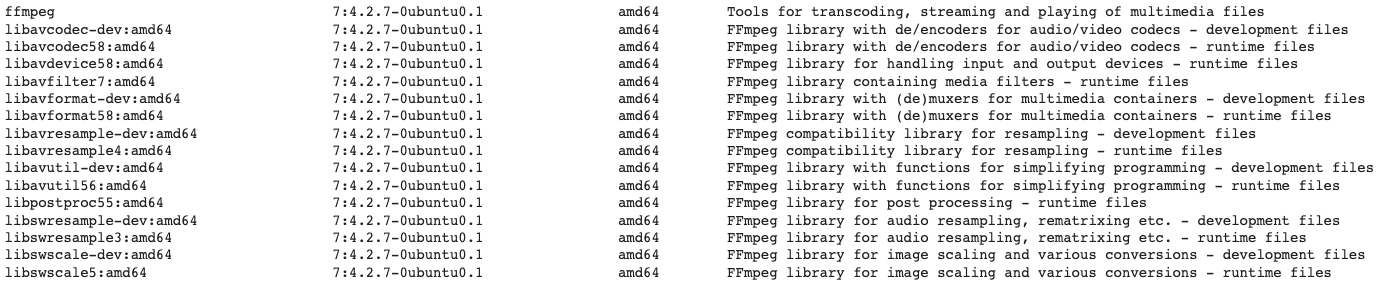

In [28]:
!sudo apt install libdw1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libdw1 is already the newest version (0.176-1.1build1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [29]:
!dpkg -l | grep -i ffmpeg

ii  ffmpeg                                 7:4.2.7-0ubuntu0.1                amd64        Tools for transcoding, streaming and playing of multimedia files
ii  libavcodec-dev:amd64                   7:4.2.7-0ubuntu0.1                amd64        FFmpeg library with de/encoders for audio/video codecs - development files
ii  libavcodec58:amd64                     7:4.2.7-0ubuntu0.1                amd64        FFmpeg library with de/encoders for audio/video codecs - runtime files
ii  libavdevice58:amd64                    7:4.2.7-0ubuntu0.1                amd64        FFmpeg library for handling input and output devices - runtime files
ii  libavfilter7:amd64                     7:4.2.7-0ubuntu0.1                amd64        FFmpeg library containing media filters - runtime files
ii  libavformat-dev:amd64                  7:4.2.7-0ubuntu0.1                amd64        FFmpeg library with (de)muxers for multimedia containers - development files
ii  libavformat58:amd64                    7:4.

Display the FFmpeg version. **BMF supports the FFmpeg verions above 4.2.x.**

In [ ]:
!ffmpeg -version

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enabl

### 1-3 install CV-CUDA

The GPU modules are implemented using CV-CUDA, **it's necessary to install CV-CUDA if you want to run the modules.**

To install CV-CUDA, we need to collect the pre-built binaries from github then install them using apt.

In [ ]:
!wget https://github.com/CVCUDA/CV-CUDA/releases/download/v0.3.1-beta/nvcv-lib-0.3.1_beta-cuda12-x86_64-linux.deb
!wget https://github.com/CVCUDA/CV-CUDA/releases/download/v0.3.1-beta/nvcv-dev-0.3.1_beta-cuda12-x86_64-linux.deb
!wget https://github.com/CVCUDA/CV-CUDA/releases/download/v0.3.1-beta/nvcv-python3.10-0.3.1_beta-cuda12-x86_64-linux.deb
!wget https://github.com/CVCUDA/CV-CUDA/releases/download/v0.3.1-beta/nvcv_python-0.3.1_beta-cp310-cp310-linux_x86_64.whl

!sudo apt install ./nvcv-lib-0.3.1_beta-cuda12-x86_64-linux.deb ./nvcv-dev-0.3.1_beta-cuda12-x86_64-linux.deb ./nvcv-python3.10-0.3.1_beta-cuda12-x86_64-linux.deb

Verify that CV-CUDA has been installed properly.

In [31]:
import cvcuda
print(cvcuda.__version__)

0.3.1-beta


### 1-3 install wurlitzer

This package is installed to show the BMF C++ logs in the colab console, otherwise only python logs are printed. This step is not necessary if you're not in a Colab or iPython notebook environment.

In [ ]:
!pip install wurlitzer
%load_ext wurlitzer

## 2. BMF GPU Transcoding & Filter Demo
 Now let's set up a gpu transcoding pipeline with common filters. The pipeline will be complete run on GPU, which means the data does not need to be copied back to CPU. We should always avoid CPU-GPU data movement as much as possible, this is an important practice in terms of performance.

### 2-1 Fetch code from github


In [57]:
!git clone https://github.com/BabitMF/bmf.git
%cd bmf/bmf/example/gpu_module

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 63.1 MB/s eta 0:00:00


### 2-2 Run the demo

The example GPU modules are implemented in the following files:

*   scale_gpu.py
*   flip_gpu.py
*   rotate_gpu.py
*   crop_gpu.py
*   blur_gpu.py

You can tell what the module does by its name. Please refer to `bmf/bmf/docs/example/Example_GpuModule.md` for detailed documentation of the GPU modules. Now let's run these modules using the following Python script


In [ ]:
import bmf

def test():
    input_video_path = "../files/lark_stream0.flv"
    output_path = "./output.mp4"

    graph = bmf.graph()
    video = graph.decode({
        "input_path": input_video_path,
        "video_params": {
            "hwaccel": "cuda"
        }
    })
    (
        video['video']
            .module('scale_gpu', {"size": '1920x1080', 'algo': 'cubic'})
            .module('crop_gpu', {'x': 960, 'y': 540, 'width': 480, 'height': 640})
            .module('flip_gpu', {'direction': 'h'}) # direction can be 'vertical', 'h', 'horizontal' or 'both'
            .module('rotate_gpu', {'angle': 'pi/8'})
            .module('blur_gpu', {'op': 'gblur', 'sigma': [0.7, 0.7], 'size': [5, 5]})
            .encode(None, {
                "output_path": output_path,
                "video_params": {
                    "codec": "hevc_nvenc",
                    "pix_fmt": "cuda",
                }
            })
            .run()
    )


if __name__ == '__main__':
    test()


Display the input and output video streams:

In [ ]:
!ffplay -i ../files/lark_stream0.mp4
!ffplay -i ./output.mp4